# scRNA-seq analysis

Here we will use 10X PBMCs scRNA-seq dataset as an example to illustrate how SIMBA performs scRNA-seq analysis

In [1]:
import os
import simba as si
si.__version__

'1.0'

In [2]:
workdir = 'result_simba_rnaseq'
si.settings.set_workdir(workdir)

Saving results in: result_simba_rnaseq


In [3]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [4]:
# make plots prettier
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

### load example data

In [5]:
adata_CG = si.datasets.rna_10xpmbc3k()


rna_10xpmbc3k.h5ad: 0.00B [00:00, ?B/s]

rna_10xpmbc3k.h5ad: 21.5MB [00:19, 1.09MB/s]                              


Downloaded to result_simba_rnaseq/data.


In [6]:
adata_CG

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype'
    var: 'gene_ids'

### preprocessing

In [7]:
si.pp.filter_genes(adata_CG,min_n_cells=3)

Before filtering: 
2700 cells, 32738 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
2700 cells, 13714 genes


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
si.pp.cal_qc_rna(adata_CG)

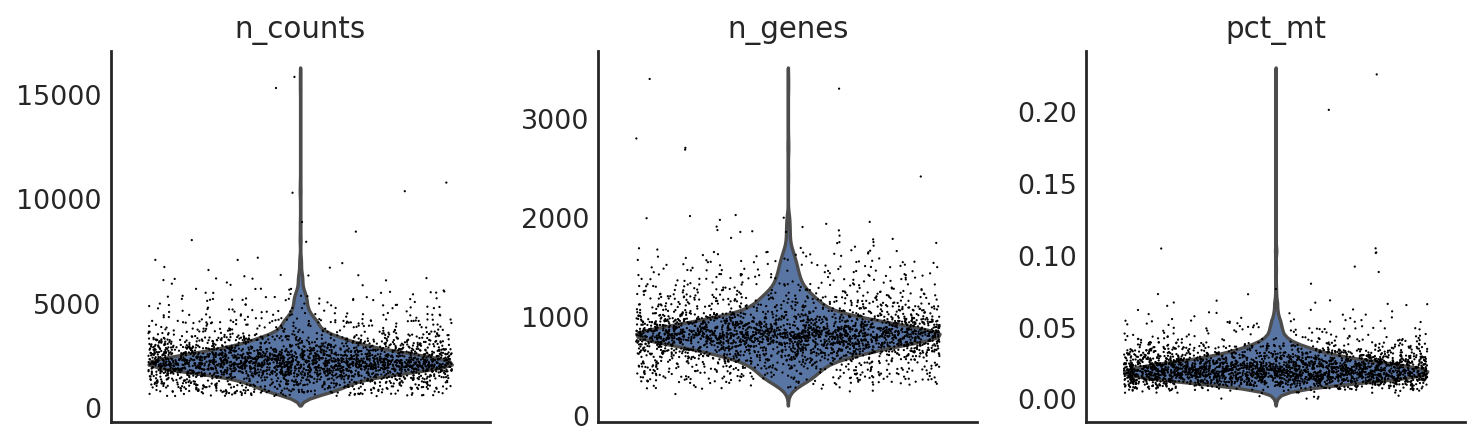

In [9]:
si.pl.violin(adata_CG,list_obs=['n_counts','n_genes','pct_mt'])

Filter out cells if needed:

```python
si.pp.filter_cells_rna(adata,min_n_genes=100)
```

In [10]:
si.pp.normalize(adata_CG,method='lib_size')

In [11]:
si.pp.log_transform(adata_CG)

Optionally, variable gene selection step can be also performed. 

```python
si.pp.select_variable_genes(adata_CG, n_top_genes=2000)
si.pl.variable_genes(adata_CG,show_texts=True)
```

This will speed up the training procedure as only variable genes are encoded into the graph. But we won't obtain the embeddings of non-variable genes.

### discretize RNA expression

In [12]:
si.tl.discretize(adata_CG,n_bins=5)

[0.48992336 1.5519998  2.1158602  2.9346128  3.9790492  7.4695992 ]


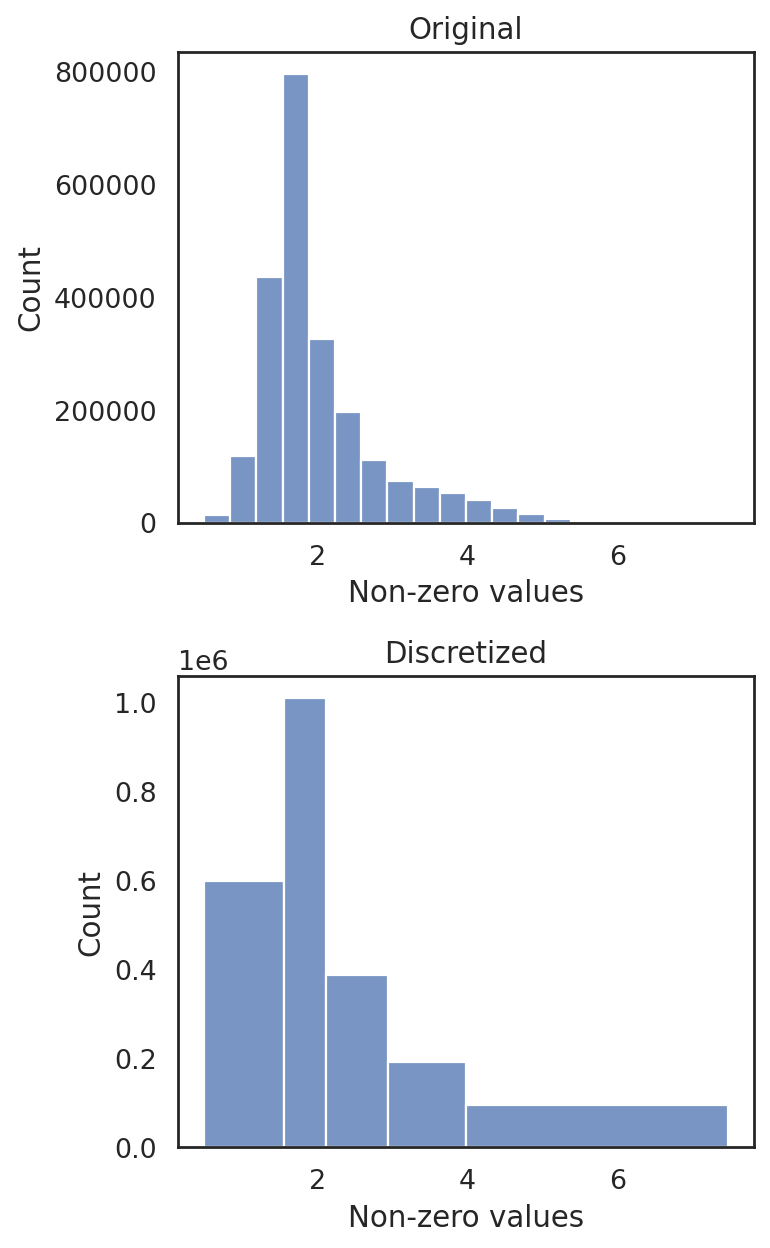

In [13]:
si.pl.discretize(adata_CG,kde=False)

### generate graph

In [14]:
si.tl.gen_graph(list_CG=[adata_CG],
                copy=False,
                use_highly_variable=False,
                dirname='graph0')

relation0: source: C, destination: G
#edges: 599381
relation1: source: C, destination: G
#edges: 1009575
relation2: source: C, destination: G
#edges: 386586
relation3: source: C, destination: G
#edges: 191955
relation4: source: C, destination: G
#edges: 95479
Total number of edges: 2282976
Writing graph file "pbg_graph.txt" to "result_simba_rnaseq/pbg/graph0" ...
Finished.


### PBG training

Before PBG training, let's take a look at the parameters:

In [15]:
si.settings.pbg_params

{'entity_path': 'result_simba_rnaseq/pbg/graph0/input/entity',
 'edge_paths': ['result_simba_rnaseq/pbg/graph0/input/edge'],
 'checkpoint_path': '',
 'entities': {'C': {'num_partitions': 1}, 'G': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r2', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r3', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
  {'name': 'r4', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 5.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 12,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.0,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_num_batch_negs': 50,
 'eval_num_uniform_ne

If no parameters need to be adjusted, the training can be simply done with:

```python
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')
```

Here we show how to adjust training-related parameters if needed. In general, weight decay `wd` is the only parameter that might need to be adjusted based on the following pbg metric plots. However, in almost all the cases, the automatically decided `wd` (enabling it by setting `auto_wd=True`) works well.

E.g. we want to change `wd_interval`:

In [16]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.015521 
dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['workers'] = 12 #The number of CPUs.

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model')

Auto-estimated weight decay is 0.015521
`.settings.pbg_params['wd']` has been updated to 0.015521
Converting input data ...
[2021-06-23 11:40:46.649703] Using the 5 relation types given in the config
[2021-06-23 11:40:46.650269] Searching for the entities in the edge files...
[2021-06-23 11:40:49.623758] Entity type C:
[2021-06-23 11:40:49.625163] - Found 2700 entities
[2021-06-23 11:40:49.625557] - Removing the ones with fewer than 1 occurrences...
[2021-06-23 11:40:49.626273] - Left with 2700 entities
[2021-06-23 11:40:49.626612] - Shuffling them...
[2021-06-23 11:40:49.628632] Entity type G:
[2021-06-23 11:40:49.628977] - Found 13714 entities
[2021-06-23 11:40:49.629267] - Removing the ones with fewer than 1 occurrences...
[2021-06-23 11:40:49.631399] - Left with 13714 entities
[2021-06-23 11:40:49.631724] - Shuffling them...
[2021-06-23 11:40:49.640308] Preparing counts and dictionaries for entities and relation types:
[2021-06-23 11:40:49.648900] - Writing count of entity type C a

> If `wd` is specified by users instead of being automatically decided, then make sure to update it in simba setting:
```python
si.settings.pbg_params = dict_config.copy()
```

The trained result can be loaded in with the following steps:

By default, it's using the current training result stored in `.setting.pbg_params`
```python
# load in graph ('graph0') info
si.load_graph_stats()
# load in model info for ('graph0')
si.load_pbg_config()
```
Users can also specify different pathss
```python
# load in graph ('graph0') info
si.load_graph_stats(path='./result_simba_rnaseq/pbg/graph0/')
# load in model info for ('graph0')
si.load_pbg_config(path='./result_simba_rnaseq/pbg/graph0/model/')
```

plotting training metrics to make sure the model is not overfitting

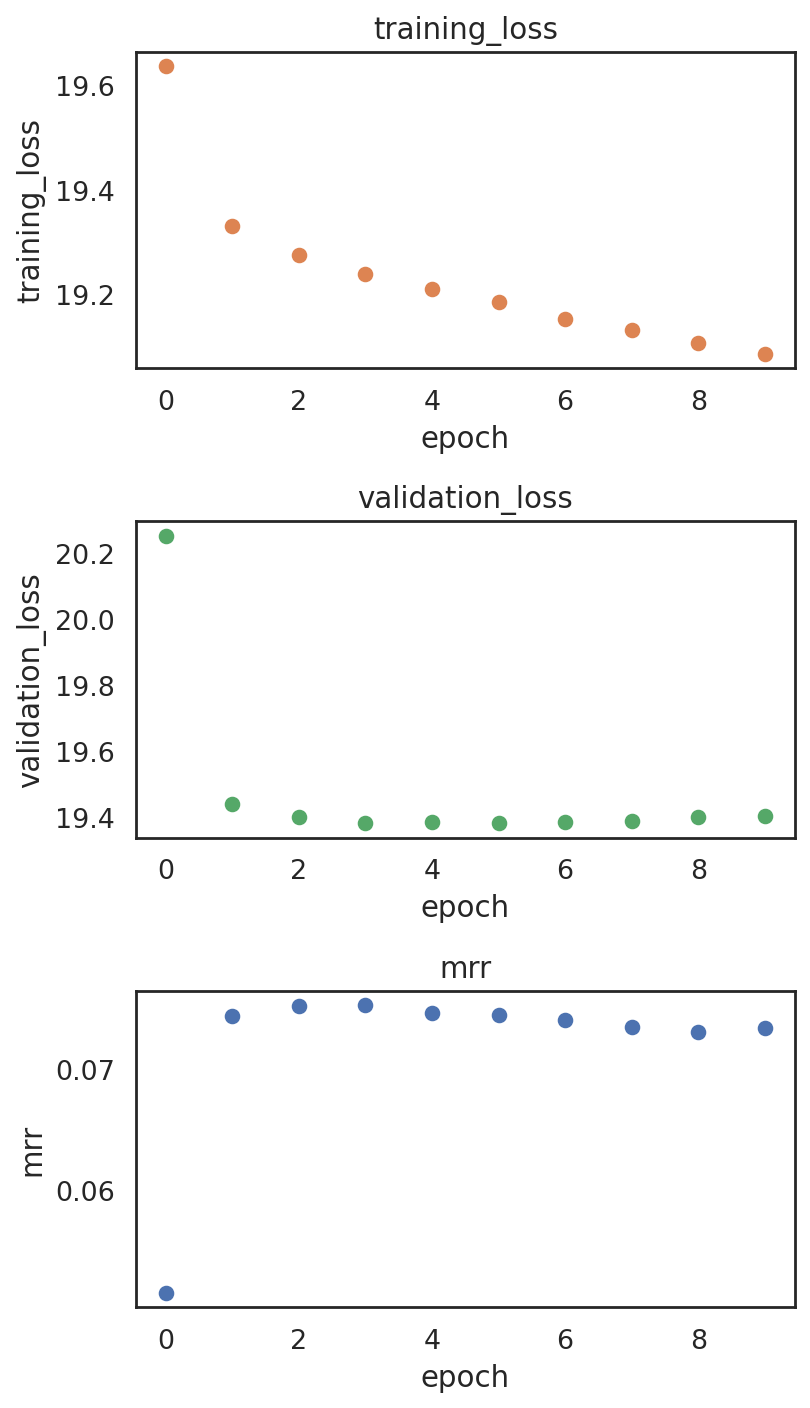

In [17]:
si.pl.pbg_metrics(fig_ncol=1)

### post-training analysis

In [18]:
palette_celltype={'B':'#1f77b4',
                  'CD4 T':'#ff7f0e', 
                  'CD8 T':'#279e68',
                  'Dendritic':"#aa40fc",
                  'CD14 Monocytes':'#d62728',
                  'FCGR3A Monocytes':'#b5bd61',
                  'Megakaryocytes':'#e377c2',
                  'NK':'#8c564b'}

In [19]:
dict_adata = si.read_embedding()

In [20]:
dict_adata

{'G': AnnData object with n_obs × n_vars = 13714 × 50,
 'C': AnnData object with n_obs × n_vars = 2700 × 50}

In [21]:
adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes

In [22]:
adata_C

AnnData object with n_obs × n_vars = 2700 × 50

In [23]:
adata_G

AnnData object with n_obs × n_vars = 13714 × 50

visualize embeddings of cells

In [24]:
## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 2700 × 50
    obs: 'celltype'

In [25]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)

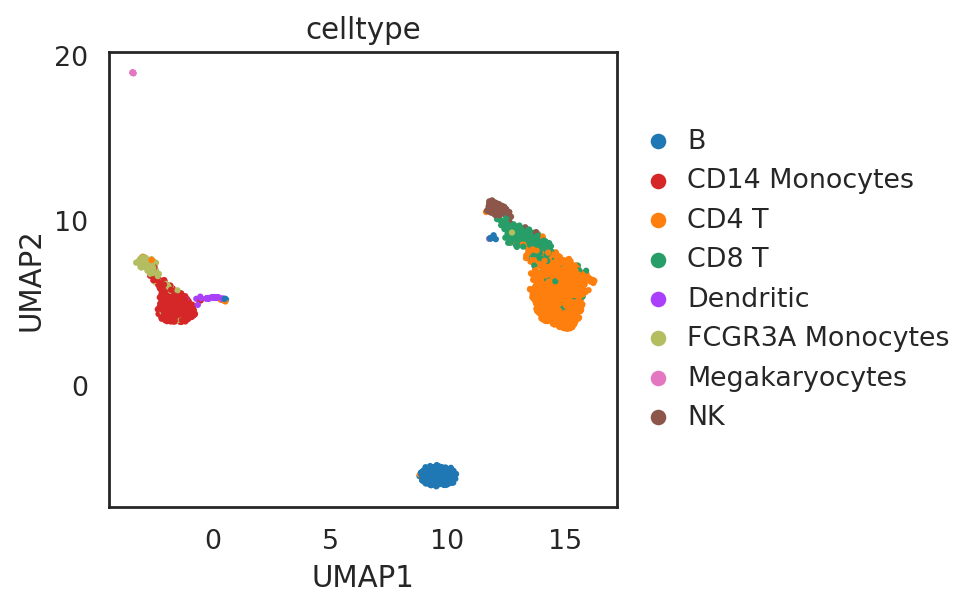

In [26]:
si.pl.umap(adata_C,color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           fig_size=(6,4),
           drawing_order='random')

visualize embeddings of cells and genes

In [27]:
# embed cells and genes into the same space
adata_all = si.tl.embed(adata_ref=adata_C,list_adata_query=[adata_G])

Performing softmax transformation for query data 0;


In [28]:
adata_all.obs.head()

,celltype,id_dataset
GACTCCTGTTGGTG-1,CD14 Monocytes,ref
TCTAACACCAGTTG-1,NK,ref
GAAACCTGTGCTAG-1,CD4 T,ref
CATTACACCAACTG-1,NK,ref
ACTCAGGATTCGTT-1,CD14 Monocytes,ref


In [29]:
## add annotations of cells and genes
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'celltype']
adata_all.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'

In [30]:
adata_all.obs.head()

,celltype,id_dataset,entity_anno
GACTCCTGTTGGTG-1,CD14 Monocytes,ref,CD14 Monocytes
TCTAACACCAGTTG-1,NK,ref,NK
GAAACCTGTGCTAG-1,CD4 T,ref,CD4 T
CATTACACCAACTG-1,NK,ref,NK
ACTCAGGATTCGTT-1,CD14 Monocytes,ref,CD14 Monocytes


In [31]:
si.tl.umap(adata_all,n_neighbors=15,n_components=2)

In [32]:
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "#607e95"

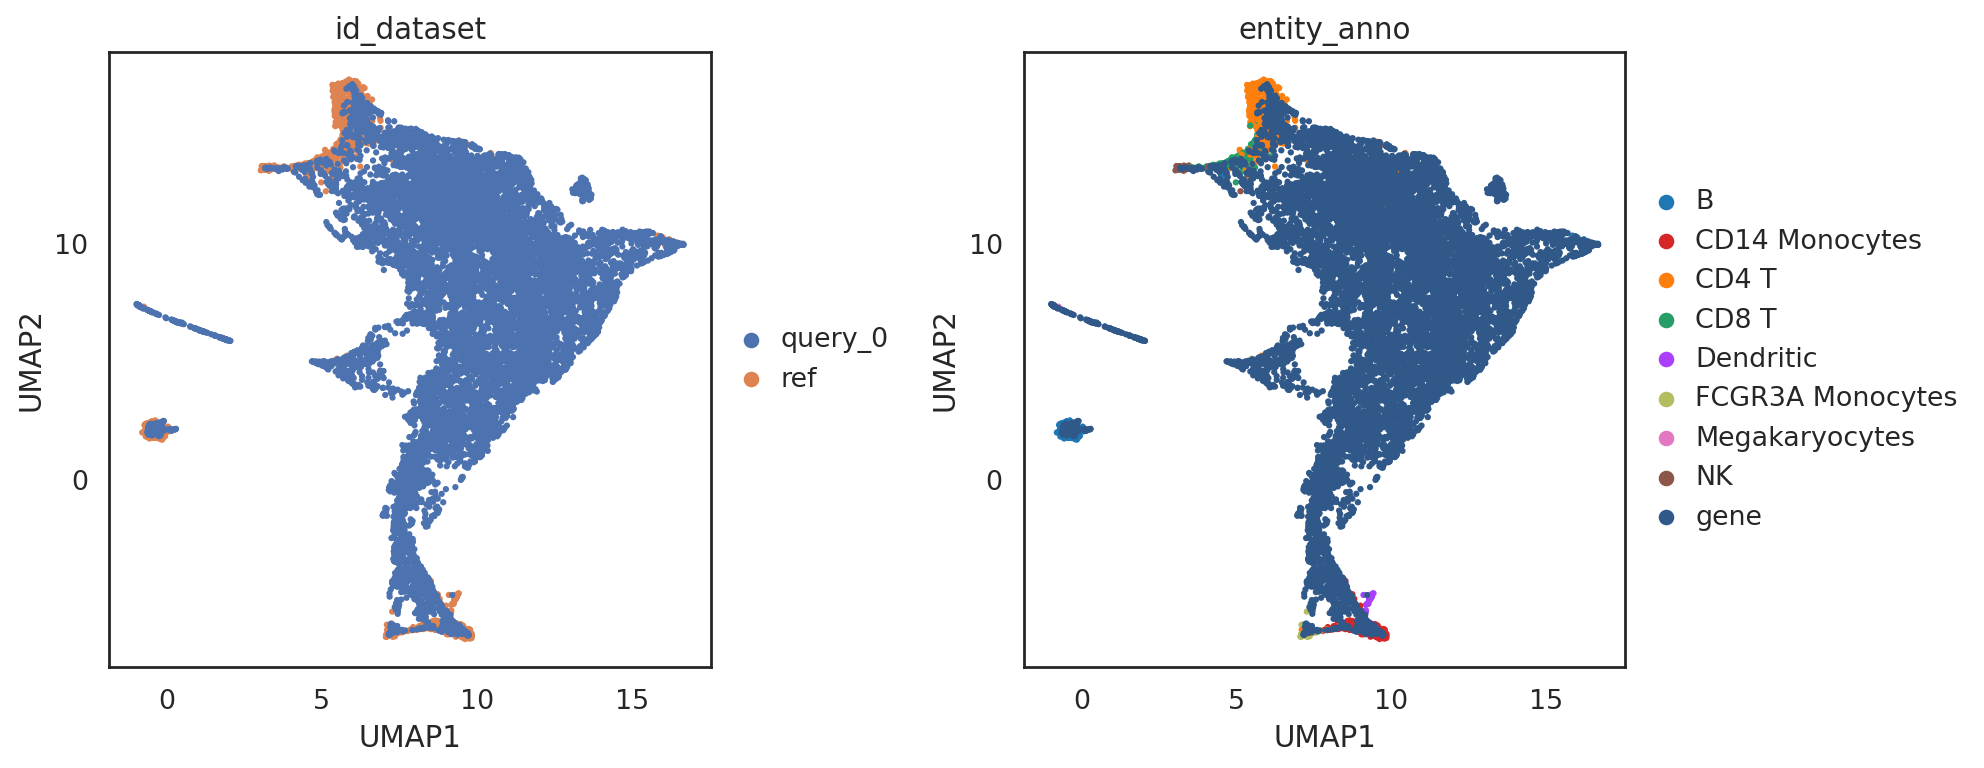

In [33]:
si.pl.umap(adata_all,color=['id_dataset','entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(6,5))

In [34]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

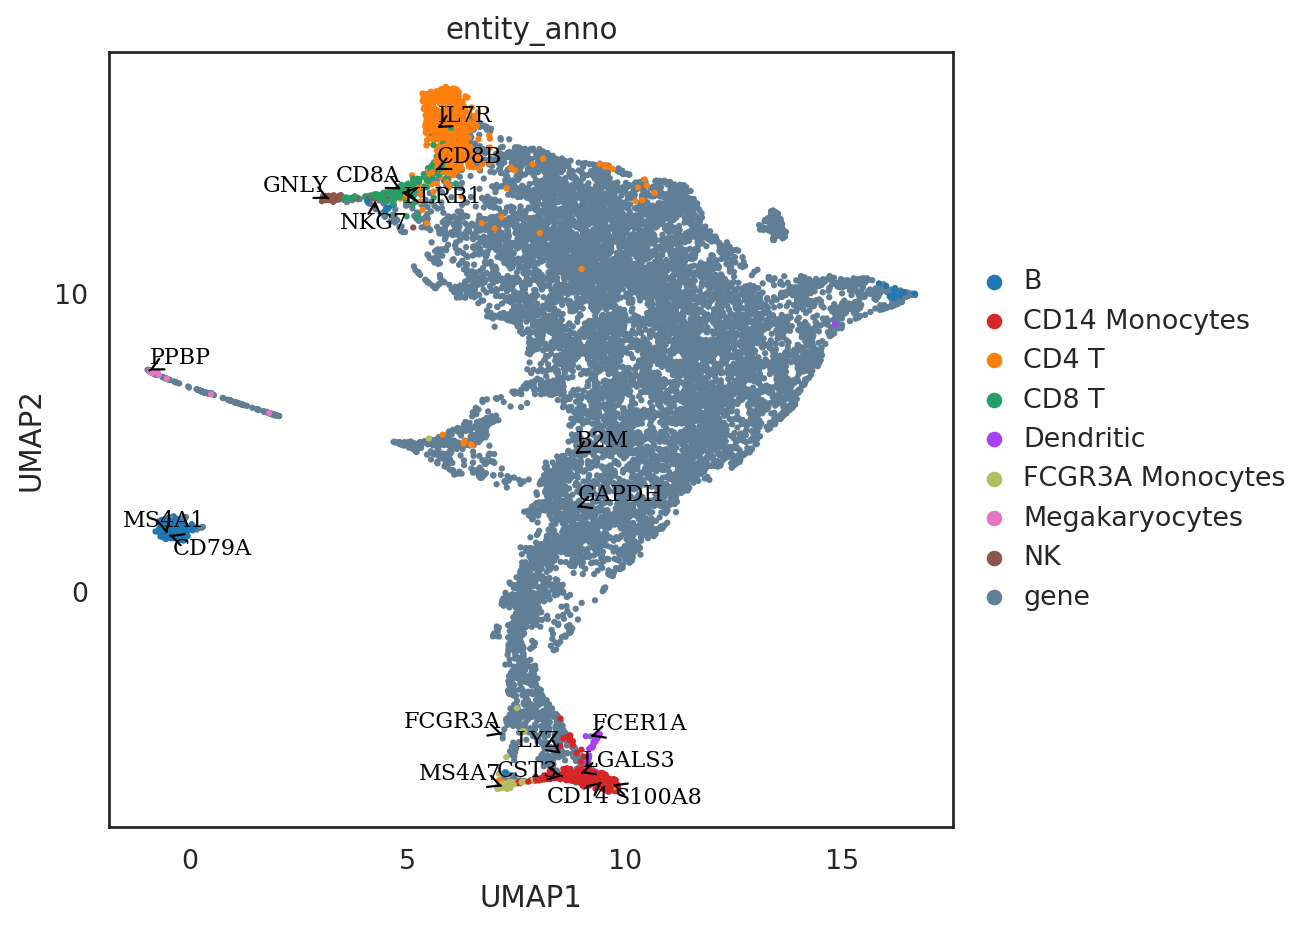

In [37]:
si.pl.umap(adata_all[::-1,],color=['entity_anno'],dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           texts=marker_genes + ['GAPDH', 'B2M'],
           show_texts=True,
           fig_size=(8,6))

SIMBA metrics

In [38]:
adata_cmp = si.tl.compare_entities(adata_ref=adata_C, adata_query=adata_G)

In [39]:
adata_cmp

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'celltype'
    var: 'max', 'std', 'gini', 'entropy'
    layers: 'norm', 'softmax'

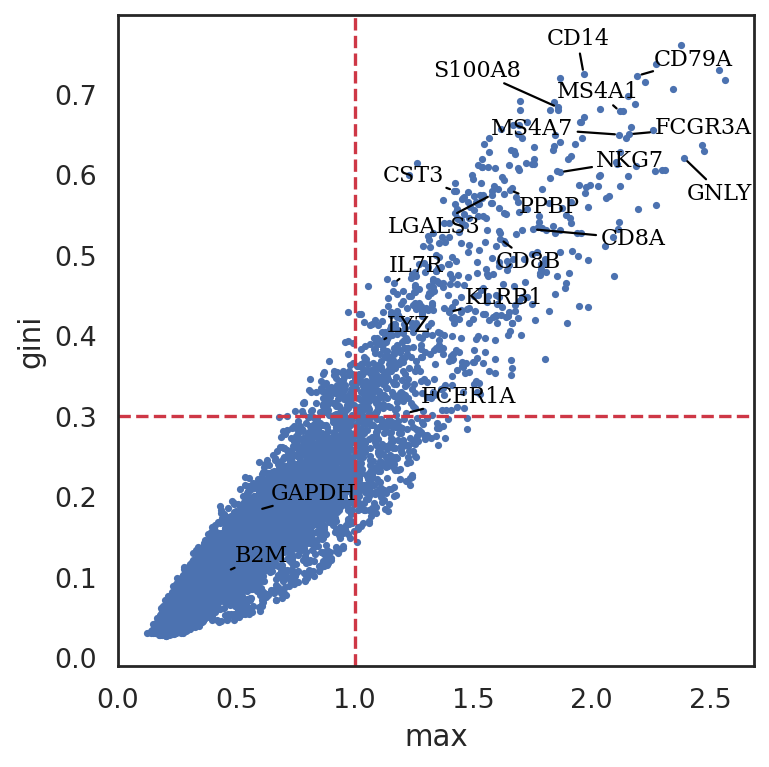

In [40]:
si.pl.entity_metrics(adata_cmp,
                     x='max',
                     y='gini',
                     show_contour=False,
                     texts=marker_genes + ['GAPDH', 'B2M'],
                     show_texts=True,
                     show_cutoff=True,
                     size=5,
                     text_expand=(1.3,1.5),
                     cutoff_x=1.,
                     cutoff_y=0.3,
                     save_fig=False)

SIMBA barcode plots

In [41]:
# add annoations of cells
adata_cmp.obs['celltype'] = adata_CG.obs.loc[adata_cmp.obs_names,'celltype']

In [42]:
list_genes = ['CST3', 'NKG7', 'MS4A1', 'GAPDH']

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


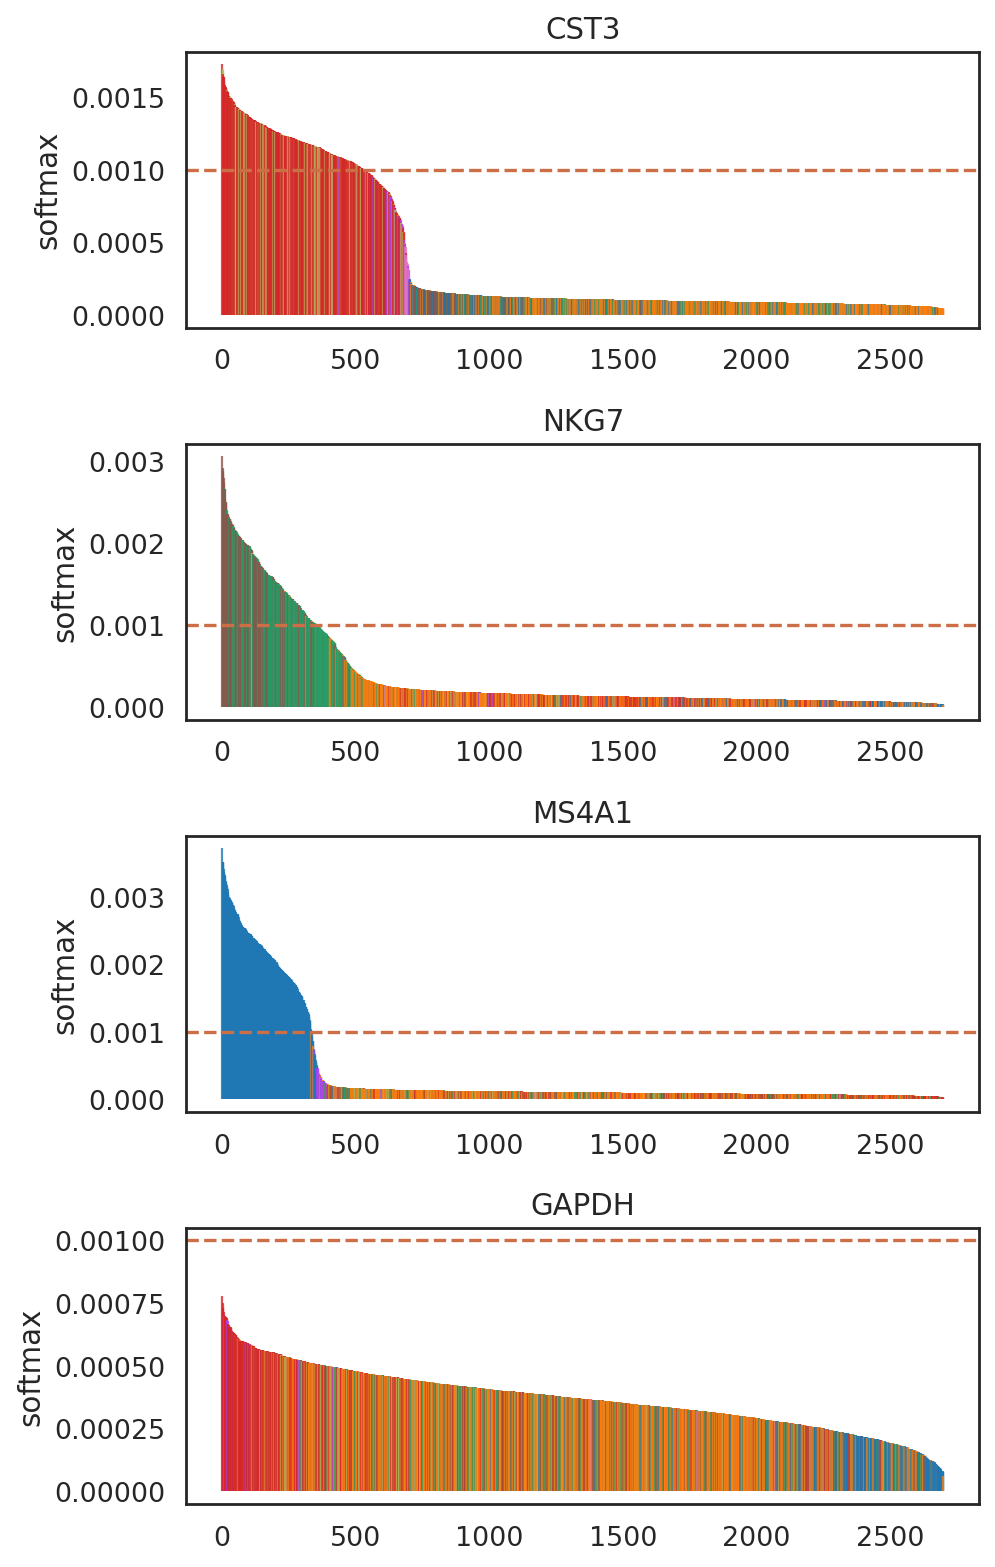

In [43]:
si.pl.entity_barcode(adata_cmp, 
                     layer='softmax',
                     entities=list_genes, 
                     anno_ref='celltype',
                     show_cutoff=True,
                     cutoff=0.001,
                     palette=palette_celltype,
                     fig_size=(6, 2.5),
                     save_fig=False)

visualize genes on umap of cells

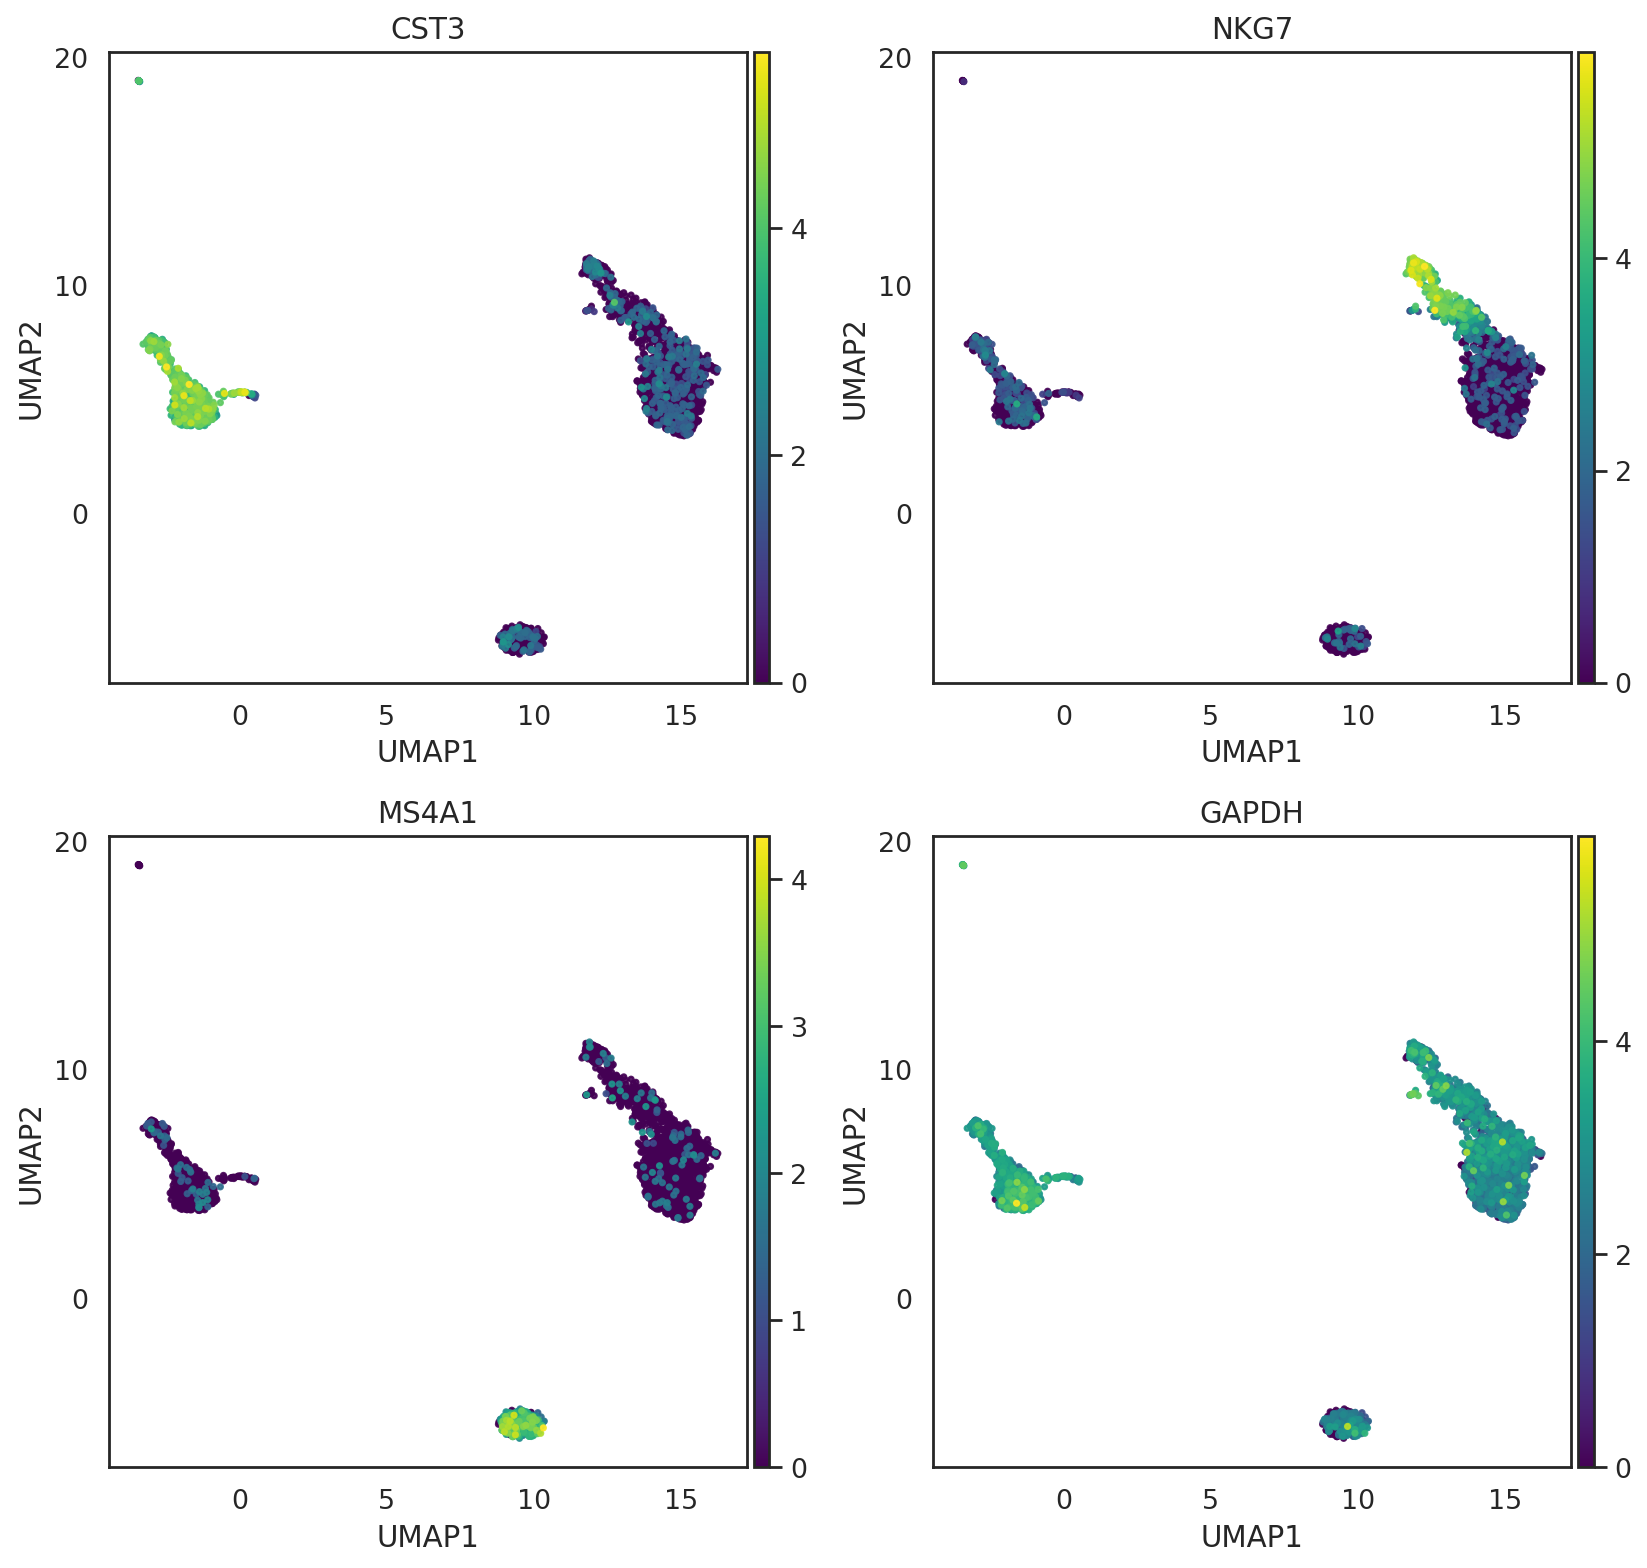

In [44]:
adata_CG.obsm['X_umap'] = adata_C[adata_CG.obs_names,].obsm['X_umap'].copy()
si.pl.umap(adata_CG,
           color=['CST3', 'NKG7', 'MS4A1', 'GAPDH'],
           drawing_order='sorted',
           size=5,
           alpha=0.9,
           fig_ncol=2,
           save_fig=False)

SIMBA queries

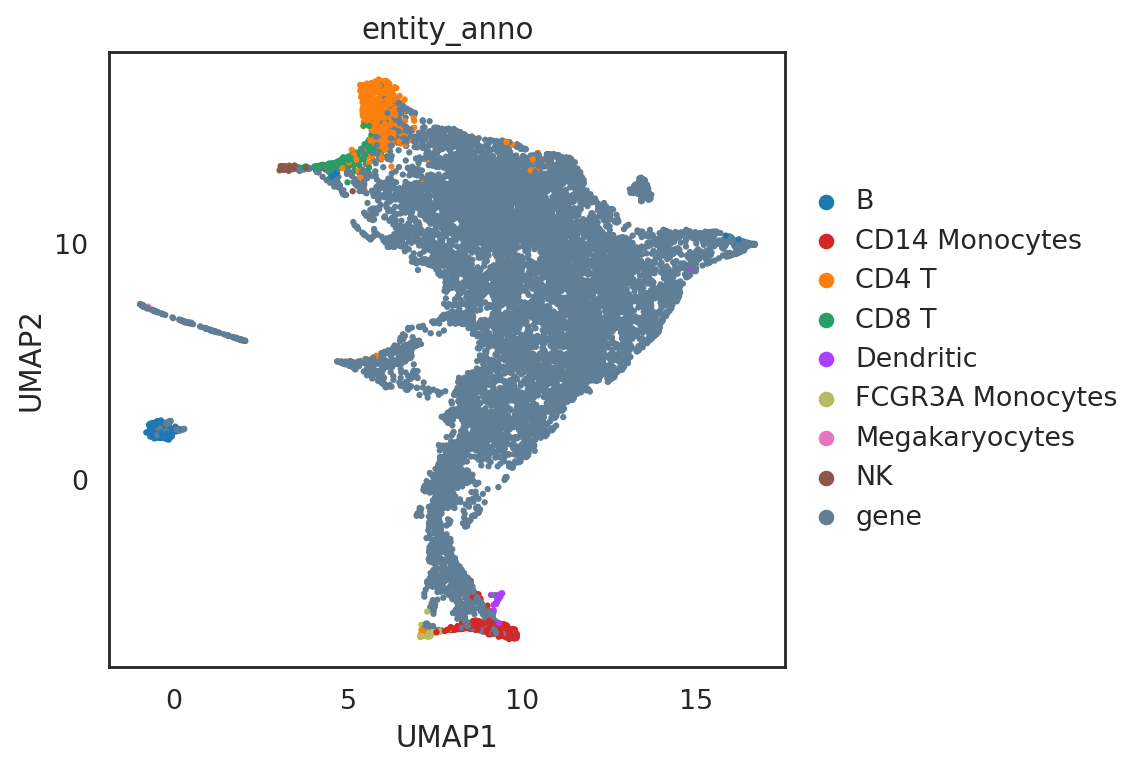

In [45]:
si.pl.umap(adata_all,
           color=['entity_anno'],dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='random',
           show_texts=False,
           fig_size=(7,5))

In [46]:
# find neighbor genes around the location [6, 16] on UMAP
query_result = si.tl.query(adata_all,
                           pin=[6,16],
                           obsm='X_umap',
                           use_radius=True,r=2,
                           anno_filter='entity_anno',
                           filters=['gene'])
print(query_result.shape)
query_result.head()

(247, 5)


,celltype,id_dataset,entity_anno,distance,query
AC013264.2,nan,query_0,gene,0.001936,0
PCSK1N,nan,query_0,gene,0.069059,0
TCEA3,nan,query_0,gene,0.082872,0
CD27,nan,query_0,gene,0.091110,0
RP11-18H21.1,nan,query_0,gene,0.105336,0


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


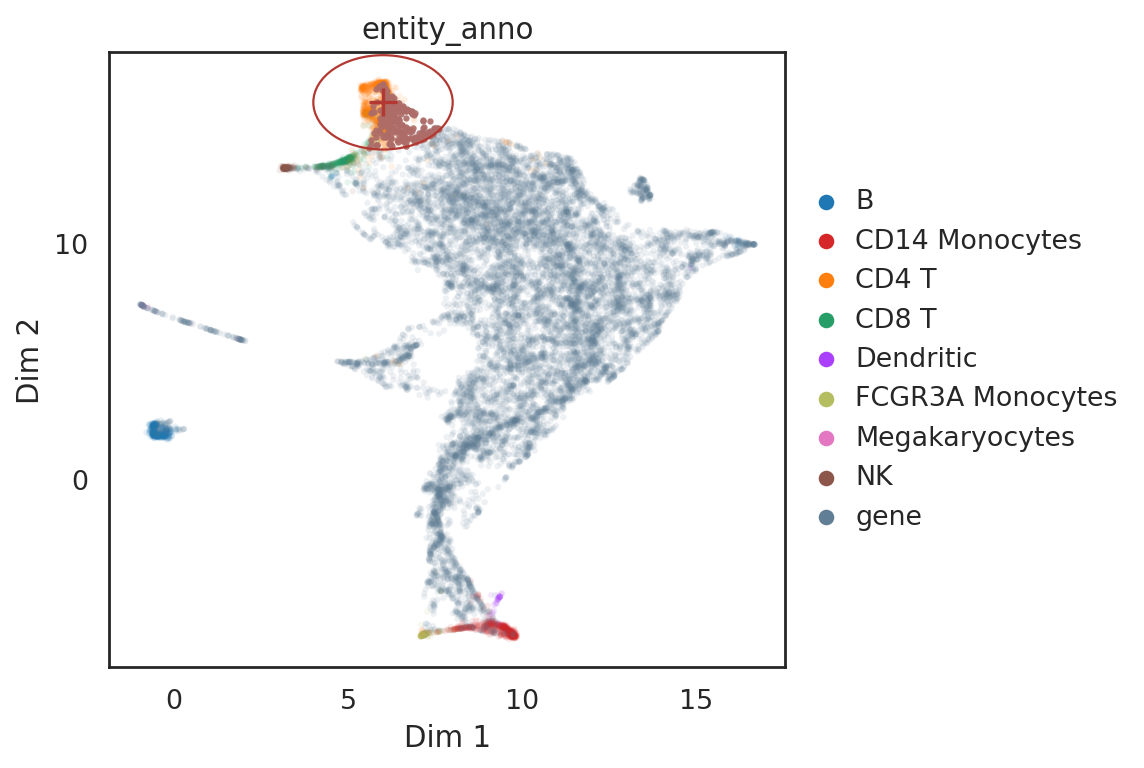

In [47]:
# show locations of pin point and its neighbor genes 
si.pl.query(adata_all,
            show_texts=False, 
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(7,5))

In [48]:
# find top 50 neighbor genes around cell "ACTCAGGATTCGTT-1" (CD14 Monocytes) in SIMBA space
query_result = si.tl.query(adata_all,
                           entity=['ACTCAGGATTCGTT-1'],
                           obsm=None,
                           use_radius=False,
                           k=50,
                           anno_filter='entity_anno',
                           filters=['gene'])
print(query_result.shape)
query_result.head()

(50, 5)


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,celltype,id_dataset,entity_anno,distance,query
JUND,nan,query_0,gene,1.719076,ACTCAGGATTCGTT-1
CLEC4E,nan,query_0,gene,1.728315,ACTCAGGATTCGTT-1
PTPRE,nan,query_0,gene,1.729887,ACTCAGGATTCGTT-1
QPCT,nan,query_0,gene,1.731332,ACTCAGGATTCGTT-1
NUP214,nan,query_0,gene,1.733139,ACTCAGGATTCGTT-1


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


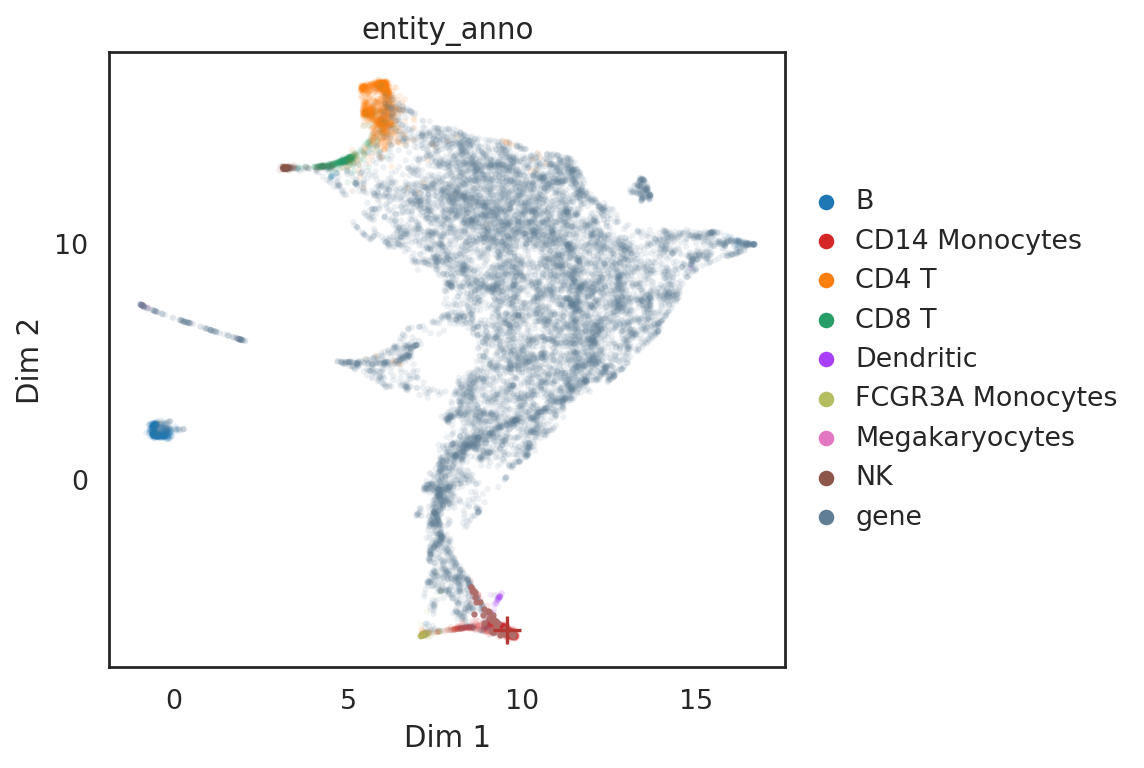

In [49]:
# show locations of entity and its neighbor genes 
si.pl.query(adata_all,
            obsm='X_umap',
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(7,5))

In [50]:
# find top 50 neighbor genes for multiples cells in SIMBA space
query_result = si.tl.query(adata_all,entity=['GATGCCCTCTCATT-1', 'CTGAAGTGGCTATG-1'],
                           obsm=None,
                           use_radius=False,
                           k=50,
                           anno_filter='entity_anno',
                           filters=['gene'],
                           )
print(query_result.shape)
query_result.head()

(100, 5)


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,celltype,id_dataset,entity_anno,distance,query
LINC00176,nan,query_0,gene,1.020504,CTGAAGTGGCTATG-1
CCR7,nan,query_0,gene,1.021033,CTGAAGTGGCTATG-1
FHIT,nan,query_0,gene,1.021289,CTGAAGTGGCTATG-1
LDLRAP1,nan,query_0,gene,1.040456,GATGCCCTCTCATT-1
TSHZ2,nan,query_0,gene,1.047881,GATGCCCTCTCATT-1


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


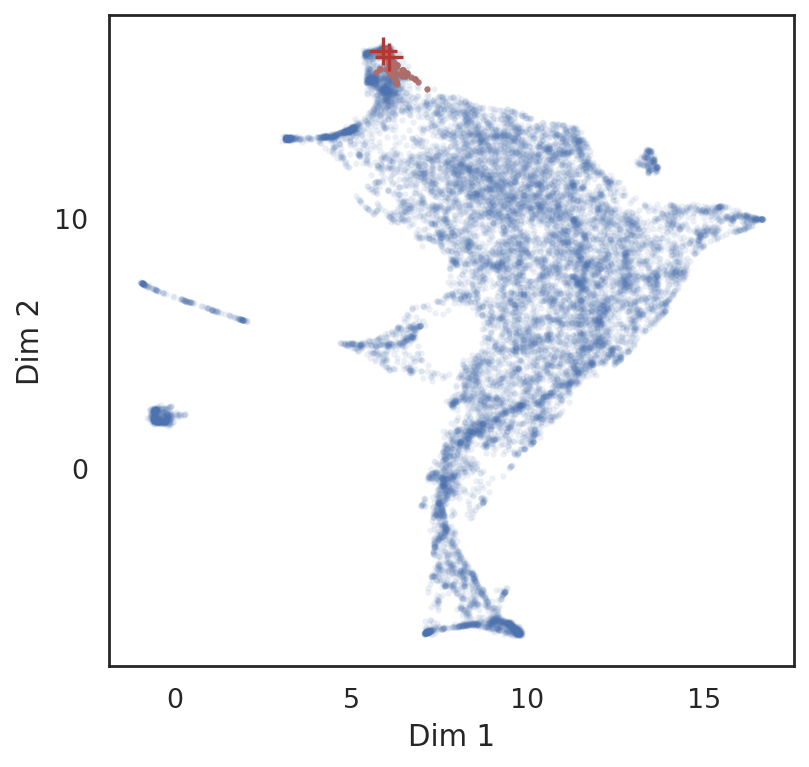

In [51]:
# show locations of entities and their neighbor genes 
si.pl.query(adata_all,
            obsm='X_umap',
            alpha=0.9,
            alpha_bg=0.1,            
            fig_size=(5,5))

In [52]:
# find neighbor entities (both cells and genes) of a given gene on UMAP
query_result = si.tl.query(adata_all,
                           entity=['CD79A'],
                           obsm='X_umap',
                           use_radius=False,
                           k=50
                           )
print(query_result.shape)
query_result.iloc[:10,]

(50, 5)


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,celltype,id_dataset,entity_anno,distance,query
CD79A,nan,query_0,gene,0.000000,CD79A
CD19,nan,query_0,gene,0.013946,CD79A
TGGATGTGACCTAG-1,B,ref,B,0.014974,CD79A
ACAAGAGAGTTGAC-1,B,ref,B,0.016267,CD79A
TACATCACGCTAAC-1,B,ref,B,0.022173,CD79A
TTATCCGACTAGTG-1,B,ref,B,0.024351,CD79A
GGAACTTGGGTAGG-1,B,ref,B,0.025603,CD79A
TGCGTAGACGGGAA-1,B,ref,B,0.027751,CD79A
TAACTCACGTACAC-1,B,ref,B,0.028147,CD79A
GATTGGACTTTCGT-1,B,ref,B,0.029059,CD79A


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


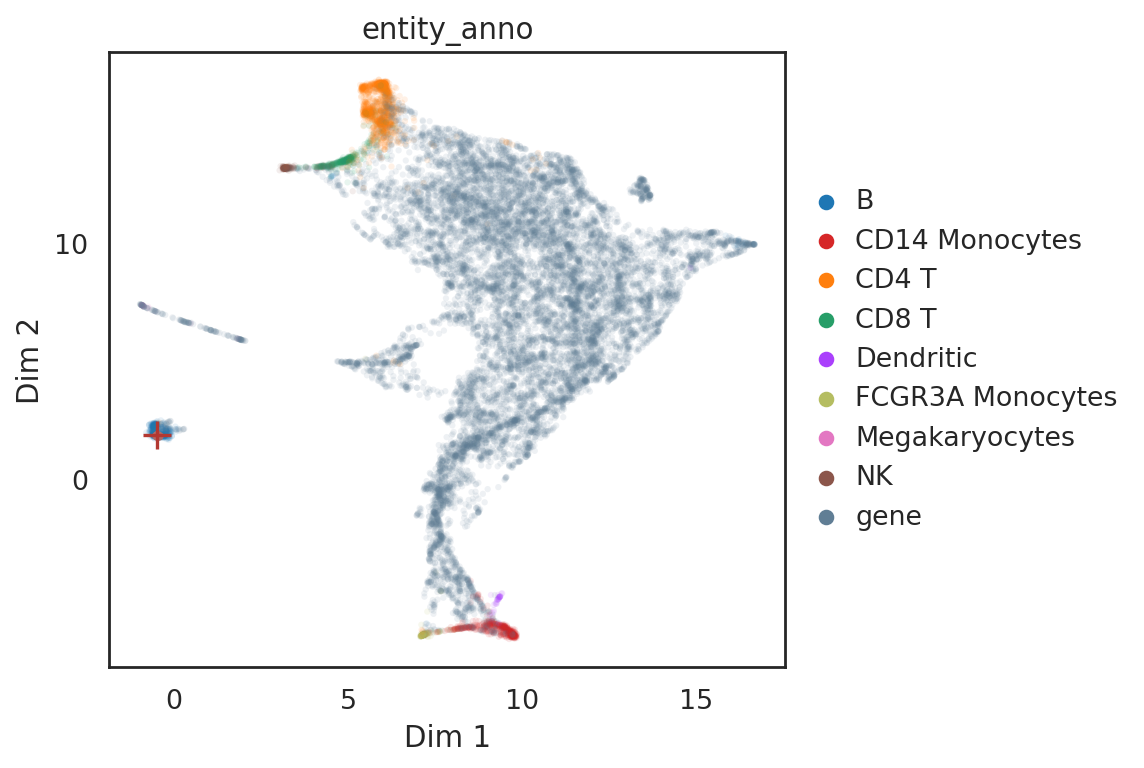

In [53]:
si.pl.query(adata_all,
            obsm='X_umap',
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            show_texts=False,
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(7,5))

### save results

In [54]:
adata_CG.write(os.path.join(workdir, 'adata_CG.h5ad'))
adata_C.write(os.path.join(workdir, 'adata_C.h5ad'))
adata_G.write(os.path.join(workdir, 'adata_G.h5ad'))
adata_all.write(os.path.join(workdir, 'adata_all.h5ad'))
adata_cmp.write(os.path.join(workdir, 'adata_cmp.h5ad'))

Read back anndata objects
```python
adata_CG = si.read_h5ad(os.path.join(workdir, 'adata_CG.h5ad'))
adata_C = si.read_h5ad(os.path.join(workdir, 'adata_C.h5ad'))
adata_G = si.read_h5ad(os.path.join(workdir, 'adata_G.h5ad'))
adata_all = si.read_h5ad(os.path.join(workdir, 'adata_all.h5ad'))
adata_cmp = si.read_h5ad(os.path.join(workdir, 'adata_cmp.h5ad'))
```